In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math

# CFPS2010

In [11]:
# 成人问卷
df1=pd.read_sas('CFPS2010/cfps2010adult_201906.sas7bdat')
df1['pid']=df1['pid'].astype(int)
# 家庭成员关系
# 需要从中识别父亲编号pid_f，再去成人问卷中匹配父亲pid
df2=pd.read_sas('CFPS2010/cfps2010famconf_report_nat072016.sas7bdat')
df2[['pid','pid_f']]=df2[['pid','pid_f']].astype(int)
# 2016年跨年库
df3=pd.read_sas('CFPS2016/cfps2016crossyearid_201807.sas7bdat')
df3['pid']=df3['pid'].astype(int)

In [12]:
# describe后发现id有为负数的，视作异常样本
# df1剔除id不在区间范围的记录
# 删除0条
out_df1=np.where((df1.pid<110001101)|(df1.pid>621872103))[0]
df1.drop(out_df1,inplace=True)
df1.reset_index(drop=True,inplace=True)

# df2剔除pid_f等于-8和77的样本的记录
# 删除35350
out_df2=np.where((df2.pid<110001101)|(df2.pid>621872104))[0] # 查看后有4条重复记录
index1=np.where((df2.pid_f==-8))[0]
df2_1=df2.drop(list(out_df2)+list(index1))
df2_1.reset_index(drop=True,inplace=True)
# 筛选所需变量
df2_2=df2_1[['pid','pid_f','TB4_A_p','TB4_A_f']]

In [13]:
# 查看有无id重复记录
df1[df1.pid.duplicated(keep=False)]# 无重复
df2_2[df2_2.duplicated(subset=['pid','pid_f'])]# 无重复
# 由于家庭关系数据库中只关注父子id，其他变量的正确性不用在意，因此只保留一条父子id对即可
# df2_2.drop_duplicates(subset=['pid','pid_f'],keep='first',inplace=True)# 剩23299

,pid,pid_f,TB4_A_p,TB4_A_f


In [14]:
# 数据匹配，需要匹配两次，分别获取个人详细信息和父亲详细信息
# 获取个人信息
# 先匹配跨年库中的相关变量
df1=pd.merge(df1,df3[['pid','INCOME_10','cfps2010eduy_im','cfps2010eduy']],on='pid',how='left')
'''
QA2：现在的户口状况
QD3：上学状态
QG3：当前工作状态
QA7_S_1：您是哪些组织成员，党员为1，其余的后面设为0，剔除缺失
QP3：健康状况
cfps2010edu_best:最高学历
cfps2010eduy_best：受教育年限(2012跨年库中)
cfps2010eduy_im：受教育年限插补
income：总收入
'''
df1_1=df1[['pid','provcd','urban','QA1AGE','GENDER','QA7_S_1',
           'QA2','QD3','QG3','QP3','INCOME','INCOME_10',
           'cfps2010edu_best','cfps2010eduy_best','cfps2010eduy_im']]
merge1=pd.merge(df1_1,df2_2,on='pid')
merge1.rename(columns={'pid_f':'fpid'},inplace=True)# 避免merge产生重复列
# 获取父亲信息
merge2=pd.merge(merge1,df1_1,left_on='fpid',right_on='pid',suffixes=['_p','_f'])
merge2.drop(['fpid'],axis=1,inplace=True)
# 将列名全改为小写，方便后续操作
for x in merge2.columns.values:
    merge2.rename(columns={x:x.lower()},inplace=True)
# 匹配了5145
merge2.head()

,pid_p,provcd_p,urban_p,qa1age_p,gender_p,qa7_s_1_p,qa2_p,qd3_p,qg3_p,qp3_p,...,qa7_s_1_f,qa2_f,qd3_f,qg3_f,qp3_f,income_f,income_10_f,cfps2010edu_best_f,cfps2010eduy_best_f,cfps2010eduy_im_f
0,110005101,11.0,1.0,19.0,0.0,6.0,3.0,0.0,1.0,2.0,...,78.0,3.0,0.0,1.0,2.0,12000.0,12000.0,4.0,12.0,NaN
1,110007101,11.0,1.0,24.0,0.0,78.0,3.0,0.0,1.0,2.0,...,78.0,1.0,0.0,1.0,2.0,12000.0,12000.0,3.0,9.0,NaN
2,110007103,11.0,1.0,20.0,1.0,78.0,1.0,0.0,1.0,1.0,...,78.0,1.0,0.0,1.0,2.0,12000.0,12000.0,3.0,9.0,NaN
3,110009105,11.0,1.0,26.0,1.0,6.0,3.0,0.0,1.0,2.0,...,6.0,3.0,0.0,1.0,1.0,12000.0,12000.0,4.0,12.0,12.0
4,110009107,11.0,1.0,21.0,1.0,6.0,3.0,1.0,0.0,2.0,...,78.0,3.0,0.0,0.0,1.0,15000.0,15000.0,1.0,2.0,6.0


In [15]:
# 筛选子辈年龄16-45,父辈年龄36-65,父子年龄差小于16(异常样本) 暂定这个范围
res1=merge2
index2=np.where((res1.qa1age_p<16)|(res1.qa1age_p>45))[0]
index3=np.where((res1.qa1age_f<36)|(res1.qa1age_f>65))[0]
res1['age_dif']=res1['qa1age_f']-res1['qa1age_p']
index4=np.where(res1['age_dif']<10)[0]
res2=res1.drop(list(index2)+list(index3)+list(index4))
# 剩余4363
res2.reset_index(drop=True,inplace=True)

In [16]:
len(res2)

4363

In [19]:
# 筛选已离开学校qd3_p=0，不要在职学生的数据（数据量比较小，且收入误差可能较大）
# school employ
# 注意需要用& |,用and,or会报错,&的优先级比==高,
index5=np.where((res2.qd3_p==0)&(res2.qg3_p==1))[0]
res3=res2.loc[index5,:]
# 剩余3142
res3.reset_index(drop=True,inplace=True)

In [20]:
len(res3)

1850

In [21]:
# 用2016跨年库中的income_10对收入进行插补
res3['income_p']=res3.apply(lambda x:x['income_10_p'] if ((np.isnan(x['income_p']))|(x['income_p']==-8)|(x['income_p']==0))
                            else x['income_p'],axis=1)
res3['income_f']=res3.apply(lambda x:x['income_10_f'] if ((np.isnan(x['income_f']))|(x['income_f']==-8)|(x['income_f']==0))
                            else x['income_f'],axis=1)

In [23]:
# 剔除收入为空，或为-8,0的样本数据，以income为标准
res4=res3.dropna(subset=['income_p','income_f']).reset_index(drop=True) # 剔除缺失值
index7=np.where((res4['income_p'].isin([-8,0]))|(res4['income_f'].isin([-8,0])))[0] # 剔除收入不适用和为0的数据
# index7=np.where((res4['income_p']==-8)|(res4['income_f']==-8))[0]
res5=res4.drop(index7) # 剩1522
res5.reset_index(drop=True,inplace=True)

In [24]:
len(res5)

1522

In [25]:
def eduy(x):
    if x==1:
        return 0
    elif x==2:
        return 6
    elif x==3:
        return 9
    elif x==4:
        return 12
    elif x==5:
        return 15
    elif x==6:
        return 16
    elif x==7:
        return 19
    elif x==8:
        return 22

In [30]:
res6.filter(regex='edu').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522 entries, 0 to 1521
Data columns (total 4 columns):
cfps2010edu_best_p     1522 non-null float64
cfps2010eduy_best_p    1522 non-null float64
cfps2010edu_best_f     1522 non-null float64
cfps2010eduy_best_f    1522 non-null float64
dtypes: float64(4)
memory usage: 47.6 KB


In [29]:
# 查看学历是否需要插补
# 先把所有-9（缺失）替换为NA
# 插补后记得剔除edu为0的，表示没有数据
res6=res5.copy()
res6['cfps2010eduy_best_p']=res6.apply(lambda x:x['cfps2010eduy_im_p'] if ((np.isnan(x['cfps2010eduy_best_p']))|(x['cfps2010eduy_best_p']==-1)) else x['cfps2010eduy_best_p'],axis=1)
res6['cfps2010eduy_best_f']=res6.apply(lambda x:x['cfps2010eduy_im_f'] if ((np.isnan(x['cfps2010eduy_best_f']))|(x['cfps2010eduy_best_f']==-1)) else x['cfps2010eduy_best_f'],axis=1)
res6['cfps2010edu_best_p']=res6.apply(lambda x:x['tb4_a_p'] if ((np.isnan(x['cfps2010edu_best_p']))|(x['cfps2010edu_best_p']==-1)) else x['cfps2010edu_best_p'],axis=1)
res6['cfps2010edu_best_f']=res6.apply(lambda x:x['tb4_a_f'] if ((np.isnan(x['cfps2010edu_best_f']))|(x['cfps2010edu_best_f']==-1)) else x['cfps2010edu_best_f'],axis=1)
res6['cfps2010eduy_best_p']=res6.apply(lambda x:eduy(x['cfps2010edu_best_p']) if ((np.isnan(x['cfps2010eduy_best_p']))|(x['cfps2010eduy_best_p']==-1)) else x['cfps2010eduy_best_p'],axis=1)
res6['cfps2010eduy_best_f']=res6.apply(lambda x:eduy(x['cfps2010edu_best_f']) if ((np.isnan(x['cfps2010eduy_best_f']))|(x['cfps2010eduy_best_f']==-1)) else x['cfps2010eduy_best_f'],axis=1)
res6.drop(['cfps2010eduy_im_p','cfps2010eduy_im_f'],axis=1,inplace=True)

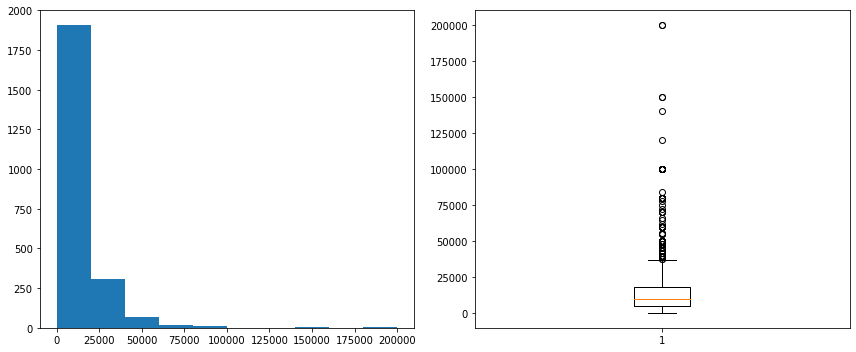

In [23]:
# 子代收入分布情况
fig_p = plt.figure(figsize=(12,5))
ax1_p = fig_p.add_subplot(121)
ax2_p=fig_p.add_subplot(122)
ax1_p.hist(res5['income_p'],bins=10)
ax2_p.boxplot(res5['income_p'])
fig_p.tight_layout()
plt.show()

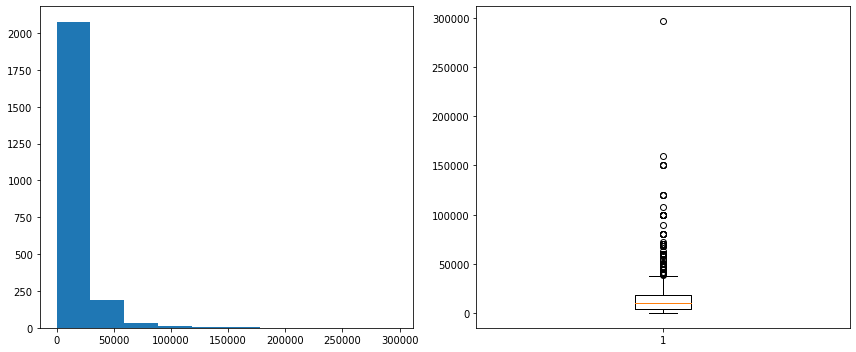

In [24]:
# 父代收入分布情况
fig_f = plt.figure(figsize=(12,5))
ax1_f = fig_f.add_subplot(121)
ax2_f=fig_f.add_subplot(122)
ax1_f.hist(res5['income_f'],bins=10)
ax2_f.boxplot(res5['income_f'])
fig_f.tight_layout()
plt.show()

In [31]:
# 计算收入的分位数
tmp_inp=np.array(res5['income_p'])
tmp_inf=np.array(res5['income_f'])
per_p=[np.percentile(tmp_inp,x) for x in [100,99,95,90,75,50,25,10,5,1,0]]
per_f=[np.percentile(tmp_inf,x) for x in [100,99,95,90,75,50,25,10,5,1,0]]
col_name=['100%max','99%','95%','90%','75%','50%','25%','10%','5%','1%','0%min']
pd.DataFrame([per_p,per_f],columns=col_name)

,100%max,99%,95%,90%,75%,50%,25%,10%,5%,1%,0%min
0,200000.0,96640.0,45000.0,33500.0,20000.0,12000.0,6000.0,2500.0,1105.0,221.0,5.0
1,160000.0,97900.0,40000.0,30000.0,20000.0,10000.0,4500.0,2000.0,1000.0,300.0,10.0


In [26]:
# 剔除首尾1%的极端数据，39条
# index8=np.where((res5.income_p<=np.percentile(tmp_inp,1))|(res5.income_p>=np.percentile(tmp_inp,99))|
#                (res5.income_f<=np.percentile(tmp_inf,1))|(res5.income_f>=np.percentile(tmp_inf,99)))[0]
# res6=res5.drop(index8)# 剩2222
# res6.reset_index(drop=True,inplace=True)

In [32]:
len(res6)

1522

In [108]:
# 根据其他相关变量剔除样本，包括缺失、不适用等
res7=res6.dropna(subset=['provcd_p','provcd_f','urban_p','urban_f','qa2_p','qa2_f',
                         'cfps2010edu_best_p','cfps2010edu_best_f','gender_p','gender_f','qp3_p','qp3_f',
                        'qa7_s_1_p','qa7_s_1_f','cfps2010eduy_best_p','cfps2010eduy_best_f']).reset_index(drop=True)
index9=np.where((res7.urban_p==-9)|(res7.urban_f==-9)|(res7.provcd_p==-9)|(res7.provcd_f==-9)|
            (res7.qa2_p.isin([-1,-2,5,79]))|(res7.qa2_f.isin([-1,-2,5,79]))|(res7.gender_p==-8)|(res7.gender_f==-8)|
            (res7.cfps2010edu_best_p==-1)|(res7.cfps2010edu_best_f==-1)|
            (res7.cfps2010eduy_best_p==-1)|(res7.cfps2010eduy_best_f==-1)|
            (res7.qa7_s_1_p.isin([-1,-2]))|(res7.qa7_s_1_f.isin([-1,-2]))|
            (res7.qp3_p.isin([-1,-8]))|(res7.qp3_f.isin([-1,-8])))[0]
res7.drop(index9,inplace=True)
res7.reset_index(drop=True,inplace=True)# 剩1519
res7['year']=2010

In [109]:
len(res7)

1519

In [110]:
# 处理政治身份，党员为1，其余为0
res7['qa7_s_1_p']=res7.apply(lambda x:1 if x['qa7_s_1_p']==1 else 0,axis=1)
res7['qa7_s_1_f']=res7.apply(lambda x:1 if x['qa7_s_1_f']==1 else 0,axis=1)

In [59]:
res7.groupby('provcd_p')['pid_p'].size()

provcd_p
11.0     12
12.0     18
13.0     97
14.0     79
21.0    113
22.0     24
23.0     45
31.0    180
32.0     35
33.0     26
34.0     12
35.0     21
36.0     21
37.0     48
41.0    149
42.0     25
43.0     32
44.0    154
45.0     35
50.0     10
51.0    112
52.0     40
53.0     53
61.0     40
62.0    138
Name: pid_p, dtype: int64

In [111]:
# 计算收入阶层
def per_num(x,tmp):
    '''
    x:income
    tmp:array(income)
    '''
    if x<=np.percentile(tmp,20):
        return 1
    elif np.percentile(tmp,20)<x<=np.percentile(tmp,40):
        return 2
    elif np.percentile(tmp,40)<x<=np.percentile(tmp,60):
        return 3
    elif np.percentile(tmp,60)<x<=np.percentile(tmp,80):
        return 4
    else:
        return 5

res7['rank_p']=res7['income_p'].map(lambda x:per_num(x,tmp_inp))
res7['rank_f']=res7['income_f'].map(lambda x:per_num(x,tmp_inf))
# 收入阶层流动
res7['rank_flow']=res7.apply(lambda x:1 if x['rank_p']>x['rank_f'] else (-1 if x['rank_p']<x['rank_f'] else 0),axis=1)

In [112]:
res7.groupby('rank_p')['pid_p'].size()

rank_p
1    336
2    354
3    250
4    276
5    303
Name: pid_p, dtype: int64

In [43]:
res7.groupby('rank_f')['pid_f'].size()

rank_f
1    308
2    347
3    283
4    301
5    280
Name: pid_f, dtype: int64

In [50]:
res7.columns.values.tolist()

['pid_p',
 'provcd_p',
 'urban_p',
 'age_p',
 'gender_p',
 'party_p',
 'hukou_p',
 'school_p',
 'employ_p',
 'heal_p',
 'income_p',
 'edu_p',
 'eduy_p',
 'pid_f',
 'provcd_f',
 'urban_f',
 'age_f',
 'gender_f',
 'party_f',
 'hukou_f',
 'school_f',
 'employ_f',
 'heal_f',
 'income_f',
 'edu_f',
 'eduy_f',
 'age_dif',
 'year',
 'rank_p',
 'rank_f',
 'rank_flow']

In [113]:
res7.rename(columns={'qa1age_p':'age_p','qa1age_f':'age_f','qa2_p':'hukou_p','qa2_f':'hukou_f',
                    'cfps2010edu_best_p':'edu_p','cfps2010edu_best_f':'edu_f',
                     'cfps2010eduy_best_p':'eduy_p','cfps2010eduy_best_f':'eduy_f',
                     'qd3_p':'school_p','qd3_f':'school_f','qg3_p':'employ_p','qg3_f':'employ_f',
                    'qp3_p':'heal_p','qp3_f':'heal_f','qa7_s_1_p':'party_p','qa7_s_1_f':'party_f'},inplace=True)

In [114]:
res7.drop(['income_10_p','income_10_f','tb4_a_p','tb4_a_f'],axis=1,inplace=True)

In [115]:
# 户口
res7[['hukou_p','hukou_f']]=res7[['hukou_p','hukou_f']].apply(lambda x:x.replace(3,0))
res7['rank_dif']=res7['rank_p']-res7['rank_f']

In [116]:
p_city_pro=pd.read_csv('data result/p_city_pro.csv',encoding='GBK',index_col=0).reset_index()
expend_farm_pro=pd.read_csv('data result/expend_farm_pro.csv',encoding='GBK',index_col=0).reset_index()
expend_edu_pro=pd.read_csv('data result/expend_edu_pro.csv',encoding='GBK',index_col=0).reset_index()
exp_GDP_pro=pd.read_csv('data result/exp_GDP_pro.csv',encoding='GBK',index_col=0).reset_index()
province=pd.read_csv('data result/province.csv',encoding='GBK')
birth_rate=pd.read_csv('data result/birth_rate.csv',encoding='GBK',index_col=0).reset_index()
cpi=pd.read_csv('data result/各省CPI_2010基期.csv',encoding='GBK',index_col=0).reset_index()
pGDP=pd.read_csv('data result/各省人均GDP.csv',encoding='GBK',index_col=0).reset_index()

In [117]:
p_city_pro=province.merge(p_city_pro,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
expend_edu_pro=province.merge(expend_edu_pro,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
expend_farm_pro=province.merge(expend_farm_pro,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
exp_GDP_pro=province.merge(exp_GDP_pro,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
birth_rate=province.merge(birth_rate,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
cpi=province.merge(cpi,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
pGDP=province.merge(pGDP,left_on='Label',right_on='index').drop(['Label','index'],axis=1)

In [118]:
# 将人均GDP调整到2010年的不变价格
col=['2010','2011','2012','2013','2014','2015','2016']
for i in col:
    pGDP[i]=pGDP[i]/cpi[i]

In [119]:
res7=res7.merge(p_city_pro[['No','2010']],left_on='provcd_p',right_on='No').rename(columns={'2010':'p_city_pro'}).drop('No',axis=1)
res7=res7.merge(expend_farm_pro[['No','2010']],left_on='provcd_p',right_on='No').rename(columns={'2010':'expend_farm_pro'}).drop('No',axis=1)
res7=res7.merge(expend_edu_pro[['No','2010']],left_on='provcd_p',right_on='No').rename(columns={'2010':'expend_edu_pro'}).drop('No',axis=1)
res7=res7.merge(exp_GDP_pro[['No','2010']],left_on='provcd_p',right_on='No').rename(columns={'2010':'exp_GDP_pro'}).drop('No',axis=1)
res7=res7.merge(birth_rate[['No','2010']],left_on='provcd_p',right_on='No').rename(columns={'2010':'birth_rate'}).drop('No',axis=1)
res7=res7.merge(pGDP[['No','2010']],left_on='provcd_p',right_on='No').rename(columns={'2010':'pGDP'}).drop('No',axis=1)
res7=res7.merge(cpi[['No','2010']],left_on='provcd_p',right_on='No').rename(columns={'2010':'cpi'}).drop('No',axis=1)

In [120]:
# 注意2010为基期，不用调整，CPI=1
res7[['income_p','income_f']]=res7.apply(lambda x:x[['income_p','income_f']]/x['cpi'],axis=1)

In [121]:
res7.to_csv('data result/model2010.csv',index=False)